In [1]:
# Env Setup
!pip install tensorflow librosa numpy matplotlib seaborn
import os, random, math
from pathlib import Path
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks

/Users/marcelo.lorenzati/.pyenv/versions/3.12.2/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/marcelo.lorenzati/.pyenv/versions/3.12.2/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/marcelo.lorenzati/.pyenv/versions/3.12.2/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/

In [2]:
# Audio Parameters
SAMPLE_RATE = 8000
FFT_SIZE = 256
WINDOW_SIZE = FFT_SIZE / SAMPLE_RATE
HOP_SIZE = int(0.010 * SAMPLE_RATE)
N_MFCC = 32
MAX_DURATION = 2.0
EXPECTED_SAMPLES = int(SAMPLE_RATE * MAX_DURATION)
FIXED_FRAMES = 80
print("Sample rate:", SAMPLE_RATE)
print("FFT size:", FFT_SIZE)
print("WINDOW size:", WINDOW_SIZE)
print("HOP size:", HOP_SIZE)

Sample rate: 8000
FFT size: 256
WINDOW size: 0.032
HOP size: 80


In [3]:
# Load file paths
lang = "es"
data_path = "../dataset"
data_root = Path(data_path + "/" + lang)   
if not data_root.exists():
    # Fallback if running from a different directory depth
    data_root = Path("voiceRover/dataset/" + lang)

label_names = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
label_to_idx = {n:i for i,n in enumerate(label_names)}

files = []
labels = []
for label in label_names:
    for f in sorted((data_root/label).glob("*.wav")):
        files.append(str(f))
        labels.append(label_to_idx[label])

print(f"Found {len(files)} files in {label_names}")

Found 40 files in ['backward', 'forward', 'left', 'right']


In [4]:
# ---- HELPER FUNCTIONS (Augmentation + Normalization) ----

def augment_audio(y, sr):
    # 1. Add Gaussian Noise
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    y = y + noise_amp * np.random.normal(size=y.shape[0])
    # 2. Time Shift
    shift_samples = int(sr * 0.1)
    shift_direction = np.random.choice([-1, 1])
    y = np.roll(y, shift_samples * shift_direction)
    return y

def extract_mfcc(path, augment=False):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    # Normalize Volume
    if y.size > 0:
        y = y / (np.max(np.abs(y)) + 1e-9)
    y, _ = librosa.effects.trim(y, top_db=20)
    
    # Augmentation
    if augment:
        y = augment_audio(y, sr)
    
    # Pad/Truncate
    if len(y) > EXPECTED_SAMPLES:
        y = y[:EXPECTED_SAMPLES]
    else:
        pad_len = EXPECTED_SAMPLES - len(y)
        if pad_len > 0:
            y = np.pad(y, (0, pad_len), mode='constant')

    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=FFT_SIZE, hop_length=HOP_SIZE)
    mfcc = mfcc.T.astype(np.float32)

    # --- NORMALIZATION (Fixes 'Flat' Image) ---
    mean = np.mean(mfcc, axis=0)
    std = np.std(mfcc, axis=0)
    mfcc = (mfcc - mean) / (std + 1e-6)
    
    return mfcc

In [5]:
# ---- DATASET EXPANSION ----
expanded_files = []
expanded_labels = []
AUGMENT_FACTOR = 50 

for f, l in zip(files, labels):
    for _ in range(AUGMENT_FACTOR):
        expanded_files.append(f)
        expanded_labels.append(l)

# Shuffle
pairs = list(zip(expanded_files, expanded_labels))
random.shuffle(pairs)
expanded_files, expanded_labels = zip(*pairs)
expanded_files = list(expanded_files)
expanded_labels = list(expanded_labels)

n_train = int(len(expanded_files) * 0.90)
print(f"New Dataset Size: {len(expanded_files)}")

New Dataset Size: 2000


In [6]:
# ---- TF PIPELINE ----
def _load_and_preprocess(path_tensor, label):
    def _py_extract_func(p):
        # Handle both bytes and string tensor types
        if isinstance(p, bytes):
            path_str = p.decode('utf-8')
        else:
            path_str = str(p.numpy().decode('utf-8')) if hasattr(p, 'numpy') else str(p)
        mf = extract_mfcc(path_str, augment=True)
        # Fix length to 80 frames
        if mf.shape[0] >= FIXED_FRAMES:
            mf_fixed = mf[:FIXED_FRAMES, :]
        else:
            pad_rows = FIXED_FRAMES - mf.shape[0]
            mf_fixed = np.vstack([mf, np.zeros((pad_rows, mf.shape[1]), dtype=np.float32)])
        return mf_fixed

    mf = tf.py_function(func=_py_extract_func, inp=[path_tensor], Tout=tf.float32)
    mf.set_shape((FIXED_FRAMES, N_MFCC))
    mf = tf.expand_dims(mf, -1)
    return mf, label

files_tf = tf.constant(expanded_files, dtype=tf.string)
labels_tf = tf.constant(expanded_labels, dtype=tf.int32)

ds_all = tf.data.Dataset.from_tensor_slices((files_tf, labels_tf))
ds_all = ds_all.shuffle(buffer_size=len(expanded_files), reshuffle_each_iteration=True)
ds_all = ds_all.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = ds_all.take(n_train).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_all.skip(n_train).batch(32).prefetch(tf.data.AUTOTUNE)

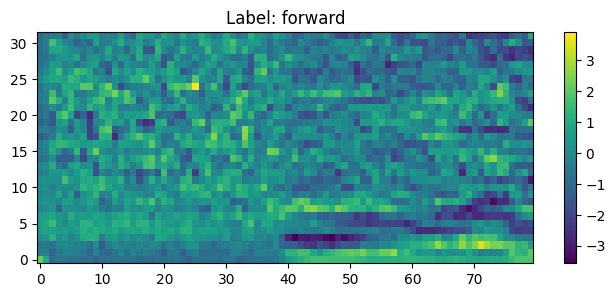

2025-12-04 20:47:49.095305: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
# Check one MFCC
for x, y in ds_all.take(1):
    plt.figure(figsize=(8,3))
    plt.imshow(x.numpy().squeeze().T, origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"Label: {label_names[y]}")
    plt.show()

In [14]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(FIXED_FRAMES, N_MFCC, 1)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.DepthwiseConv2D((3,3), padding='same', activation='relu'),
    layers.Conv2D(24, (3,3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(label_names), activation='softmax'),
])
model.compile(optimizer='adamw', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 80, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 80, 32, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 32, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 24)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,732 (18.48 KB)

 Trainable params: 4,732 (18.48 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0
)


history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[model_checkpoint_callback, early_stopping, lr_scheduler])

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.3956 - loss: 1.3246 - val_accuracy: 0.4650 - val_loss: 1.2902 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4467 - loss: 1.2308 - val_accuracy: 0.4150 - val_loss: 1.2147 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4906 - loss: 1.1320 - val_accuracy: 0.5000 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5789 - loss: 1.0152 - val_accuracy: 0.6350 - val_loss: 0.9301 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.6711 - loss: 0.8634 - val_accuracy: 0.7050 - val_loss: 0.7544 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.7167 - loss: 0.7366 - val_accuracy: 0.7750 - val_loss: 0.7251 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.7678 - l

In [26]:
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  # +1 because epochs are 1-indexed

print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best epoch: {best_epoch}")

#model.save("model_1.keras")

Best validation accuracy: 1.0000
Best epoch: 36


Scanning dataset at: ../dataset/es...
Testing 10 files for class 'backward'...
Testing 10 files for class 'forward'...
Testing 10 files for class 'left'...
Testing 10 files for class 'right'...

OVERALL ACCURACY: 100.00%


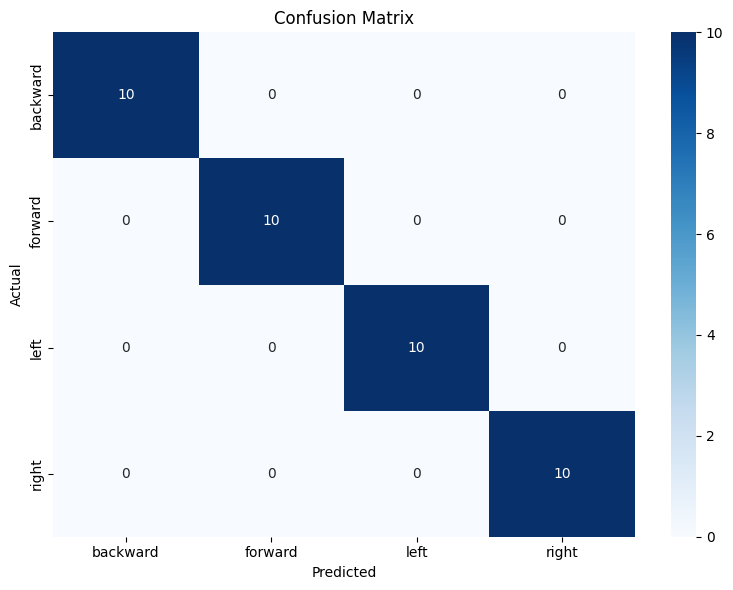


⚠️  Low Confidence Predictions (<70%):
  - record_9.wav: Real='forward' vs Pred='forward' (Conf: 0.62)
  - record_1.wav: Real='right' vs Pred='right' (Conf: 0.42)


In [28]:
# ---- ROBUST EVALUATION & CONFUSION MATRIX ----
import matplotlib.pyplot as plt
import seaborn as sns # Optional, makes plots prettier if installed
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_whole_dataset(model, data_root, label_names):
    y_true = []
    y_pred = []
    low_confidence_files = []
    
    print(f"Scanning dataset at: {data_root}...")
    
    # 1. Iterate over every file in the dataset
    for label_idx, label in enumerate(label_names):
        folder = data_root / label
        files = list(folder.glob("*.wav"))
        print(f"Testing {len(files)} files for class '{label}'...")
        
        for f in files:
            # Run prediction logic manually to keep it fast
            # (Reusing your extraction logic)
            mfcc = extract_mfcc(str(f), augment=False)
            
            # Shape fix
            if mfcc.shape[0] >= FIXED_FRAMES:
                mfcc_fixed = mfcc[:FIXED_FRAMES, :]
            else:
                pad_rows = FIXED_FRAMES - mfcc.shape[0]
                mfcc_fixed = np.vstack([mfcc, np.zeros((pad_rows, mfcc.shape[1]), dtype=np.float32)])
            
            x = np.expand_dims(mfcc_fixed, axis=0) # Batch dim
            x = np.expand_dims(x, axis=-1)         # Channel dim
            
            # Predict
            prediction = model.predict(x, verbose=0)
            predicted_idx = np.argmax(prediction[0])
            confidence = prediction[0][predicted_idx]
            
            # Store results
            y_true.append(label_idx)
            y_pred.append(predicted_idx)
            
            # Flag low confidence (< 70%)
            if confidence < 0.70:
                low_confidence_files.append((f.name, label, label_names[predicted_idx], confidence))

    # 2. Calculate Metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    
    print("\n" + "="*40)
    print(f"OVERALL ACCURACY: {accuracy * 100:.2f}%")
    print("="*40)

    # 3. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    # Check if seaborn is available for a nicer heatmap, otherwise use standard matplotlib
    try:
        import seaborn as sns
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_names, yticklabels=label_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
    except ImportError:
        # Fallback if seaborn not installed
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        
        # Loop over data dimensions and create text annotations.
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

    # 4. Report Problematic Files
    if low_confidence_files:
        print("\n⚠️  Low Confidence Predictions (<70%):")
        for name, actual, pred, conf in low_confidence_files:
            print(f"  - {name}: Real='{actual}' vs Pred='{pred}' (Conf: {conf:.2f})")
    else:
        print("\n✅ No low confidence predictions found!")

# Run the evaluation
evaluate_whole_dataset(model, data_root, label_names)

In [29]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
    
print("Model saved to model.tflite")
!xxd -i model.tflite > model_data.cc  # Uncomment to generate C array on Linux/Mac

INFO:tensorflow:Assets written to: /var/folders/5g/kt_lprmn5y17wm7lwrvyjt340000gr/T/tmptc8p89r_/assets


INFO:tensorflow:Assets written to: /var/folders/5g/kt_lprmn5y17wm7lwrvyjt340000gr/T/tmptc8p89r_/assets


Saved artifact at '/var/folders/5g/kt_lprmn5y17wm7lwrvyjt340000gr/T/tmptc8p89r_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 32, 1), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  12953282000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12953281232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12953280848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12953281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12953279888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12953281616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397154064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397153680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397152912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397151184: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/marcelo.lorenzati/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764893541.666989  130826 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764893541.667144  130826 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-04 21:12:21.667405: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/5g/kt_lprmn5y17wm7lwrvyjt340000gr/T/tmptc8p89r_
2025-12-04 21:12:21.667906: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-04 21:12:21.667912: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/5g/kt_lprmn5y17wm7lwrvyjt340000gr/T/tmptc8p89r_
2025-12-04 21:12:21.674137: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-04 21:12:21.700

Model saved to model.tflite
